In [3]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('dataset.csv')

# Handling Missing Data
# Numerical columns - Impute with median
numerical_cols = ['SumInsured', 'TotalPremium', 'cubiccapacity']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Categorical columns - Impute with mode
categorical_cols = ['MaritalStatus', 'Gender', 'Citizenship', 'LegalType']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Remove rows with excessive missing data (threshold 70%)
df = df.dropna(thresh=int(0.7*df.shape[1]), axis=0)

# Feature Engineering

# 1. Age of Car (CarAge)
df['TransactionDate'] = pd.to_datetime(df['TransactionMonth'])  # Convert to datetime
df['CarAge'] = df['TransactionDate'].dt.year - df['RegistrationYear']

# 2. Insured Value per Year (InsuredPerYear)
df['InsuredPerYear'] = df['SumInsured'] / df['CarAge'].replace(0, 1)  # Avoid division by zero

# 3. Claims Frequency (ClaimsPerYear)
df['ClaimsPerYear'] = df['TotalClaims'] / df['CarAge'].replace(0, 1)

# 4. Client Risk Profile based on client info
df['ClientRiskScore'] = np.where(df['IsVATRegistered'] == 'Yes', 1, 0)
df['ClientRiskScore'] += np.where(df['MaritalStatus'] == 'Single', 1, 0)
df['ClientRiskScore'] += np.where(df['Citizenship'] == 'South Africa', 0, 1)  # Higher risk if not South African

# 5. Vehicle Risk Score based on car info
df['VehicleRiskScore'] = np.where(df['VehicleType'] == 'Passenger Vehicle', 1, 0)
df['VehicleRiskScore'] += df['Cylinders'] / df['Cylinders'].max()  # Normalize cylinder count as risk factor

# Save the processed data
df.to_csv('processed_insurance_data.csv', index=False)

print("Data preparation and feature engineering complete.")

C:\Users\biement fanteye\AppData\Local\Temp\ipykernel_4264\2887755012.py:5: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


Data preparation and feature engineering complete.


In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the processed dataset
df = pd.read_csv('processed_insurance_data.csv')

# One-hot encoding for categorical columns with many categories
# This avoids creating too many dummy variables for high-cardinality features.
one_hot_cols = ['Province', 'MainCrestaZone', 'SubCrestaZone', 'VehicleType', 'make', 'Model', 'bodytype']

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Label encoding for binary or ordinal categorical columns
label_cols = ['Gender', 'MaritalStatus', 'IsVATRegistered', 'AlarmImmobiliser', 'TrackingDevice', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder']

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding
for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Save the fully encoded dataset
df.to_csv('encoded_insurance_data.csv', index=False)

print("Categorical data encoding complete.")

C:\Users\biement fanteye\AppData\Local\Temp\ipykernel_4264\2596673082.py:5: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('processed_insurance_data.csv')


Categorical data encoding complete.


In [5]:
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
       'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
       'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
       'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims', 'TransactionDate', 'CarAge', 'InsuredPerYear',
       'ClaimsPerYear', 'ClientRiskScore', 'VehicleRiskScore'

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the encoded dataset
df = pd.read_csv('encoded_insurance_data.csv')

# Define your target variable and features
X = df.drop(columns=['TotalPremium', 'TotalClaims'])  # Features
y = df['TotalPremium']  # Target variable (adjust as necessary)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the train and test sets to CSV (optional)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Train-test split complete.")

C:\Users\biement fanteye\AppData\Local\Temp\ipykernel_4264\3969896274.py:5: DtypeWarning: Columns (8,9,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('encoded_insurance_data.csv')


Train-test split complete.


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('encoded_insurance_data.csv')

# Convert date columns to datetime format (assuming 'TransactionDate' is the date column)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract relevant features from the date
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day

# Drop the original date column if it's no longer needed
df.drop(columns=['TransactionDate'], inplace=True)

# Define your target variable and features
X = df.drop(columns=['TotalPremium', 'TotalClaims'])  # Features
y = df['TotalPremium']  # Target variable

# Step 1: Check for non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

# Step 2: Replace empty strings or spaces with NaN
X.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

# Step 3: Handle missing values (you can drop or fill them)
X.fillna(0, inplace=True)  # Filling missing values with 0 (you can use mean/median if preferred)

# Step 4: Ensure all features are numeric
print(X.dtypes)

C:\Users\biement fanteye\AppData\Local\Temp\ipykernel_4264\201061600.py:9: DtypeWarning: Columns (8,9,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('encoded_insurance_data.csv')


Non-numeric columns: Index(['Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType',
       'Country', 'ItemType', 'VehicleIntroDate', 'CapitalOutstanding',
       'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType',
       'CoverGroup', 'Section', 'Product', 'StatutoryClass',
       'StatutoryRiskType'],
      dtype='object')
UnderwrittenCoverID     int64
PolicyID                int64
TransactionMonth        int32
IsVATRegistered         int64
Citizenship            object
                        ...  
bodytype_S/D             bool
bodytype_S/W             bool
bodytype_SUV             bool
TransactionYear         int32
TransactionDay          int32
Length: 592, dtype: object


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('encoded_insurance_data.csv')

# Convert date columns to datetime format (assuming 'TransactionDate' is the date column)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract relevant features from the date
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day

# Drop the original date column if it's no longer needed
df.drop(columns=['TransactionDate'], inplace=True)

# Step 1: Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Step 2: Convert categorical columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Define your target variable and features
X = df.drop(columns=['TotalPremium', 'TotalClaims'])  # Features
y = df['TotalPremium']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Evaluate Linear Regression
lin_mse = mean_squared_error(y_test, y_pred_lin)
lin_r2 = r2_score(y_test, y_pred_lin)
print(f'Linear Regression - MSE: {lin_mse:.2f}, R2: {lin_r2:.2f}')

C:\Users\biement fanteye\AppData\Local\Temp\ipykernel_4264\1517319579.py:9: DtypeWarning: Columns (8,9,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('encoded_insurance_data.csv')


Categorical columns: Index(['Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType',
       'Country', 'ItemType', 'VehicleIntroDate', 'CapitalOutstanding',
       'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType',
       'CoverGroup', 'Section', 'Product', 'StatutoryClass',
       'StatutoryRiskType'],
      dtype='object')
Linear Regression - MSE: 14878.05, R2: 0.46


In [16]:
# 2. Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Evaluate Random Forest
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f'Random Forest - MSE: {rf_mse:.2f}, R2: {rf_r2:.2f}')

Random Forest - MSE: 1942.04, R2: 0.93


In [18]:
import numpy as np

# Convert pandas DataFrames to numpy arrays
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Fit the XGBoost model
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_train_np, y_train)

# Make predictions
y_pred_xgb = xgb_reg.predict(X_test_np)

# Evaluate XGBoost
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - MSE: {xgb_mse:.2f}, R2: {xgb_r2:.2f}')

XGBoost - MSE: 7939.03, R2: 0.71


In [19]:
from sklearn.metrics import mean_absolute_error

# For each model
lin_mae = mean_absolute_error(y_test, y_pred_lin)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

print(f'Linear Regression - MAE: {lin_mae:.2f}')
print(f'Random Forest - MAE: {rf_mae:.2f}')
print(f'XGBoost - MAE: {xgb_mae:.2f}')

Linear Regression - MAE: 53.37
Random Forest - MAE: 7.59
XGBoost - MAE: 39.23


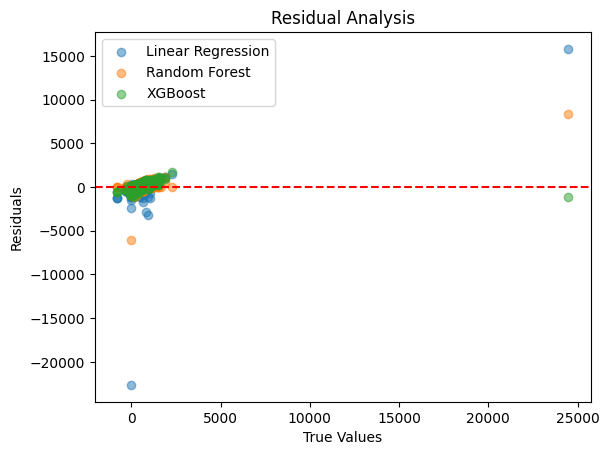

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test - y_pred_lin, label="Linear Regression", alpha=0.5)
plt.scatter(y_test, y_test - y_pred_rf, label="Random Forest", alpha=0.5)
plt.scatter(y_test, y_test - y_pred_xgb, label="XGBoost", alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Residual Analysis')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

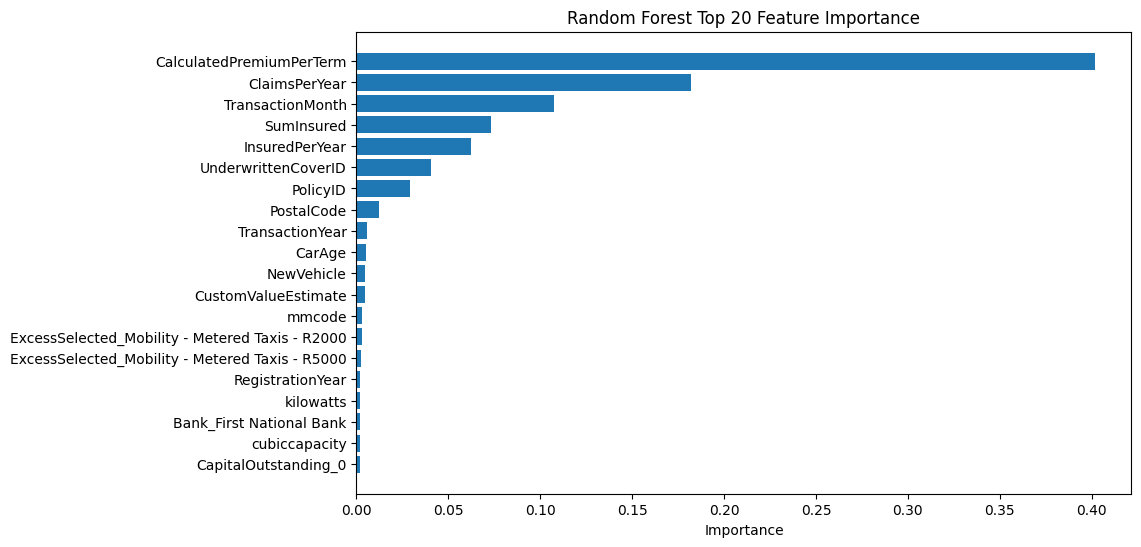

In [24]:
# Random Forest Feature Importance using the trained model (rf_reg)
import matplotlib.pyplot as plt
import numpy as np

# Get the feature importances from the trained model
rf_importances = rf_reg.feature_importances_
# Get the indices of the top 20 important features
rf_indices = np.argsort(rf_importances)[-20:]

# Plot the top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(range(len(rf_indices)), rf_importances[rf_indices], align='center')
# Use the feature names from the X_train dataframe
plt.yticks(range(len(rf_indices)), [X_train.columns[i] for i in rf_indices])
plt.xlabel('Importance')
plt.title('Random Forest Top 20 Feature Importance')
plt.show()

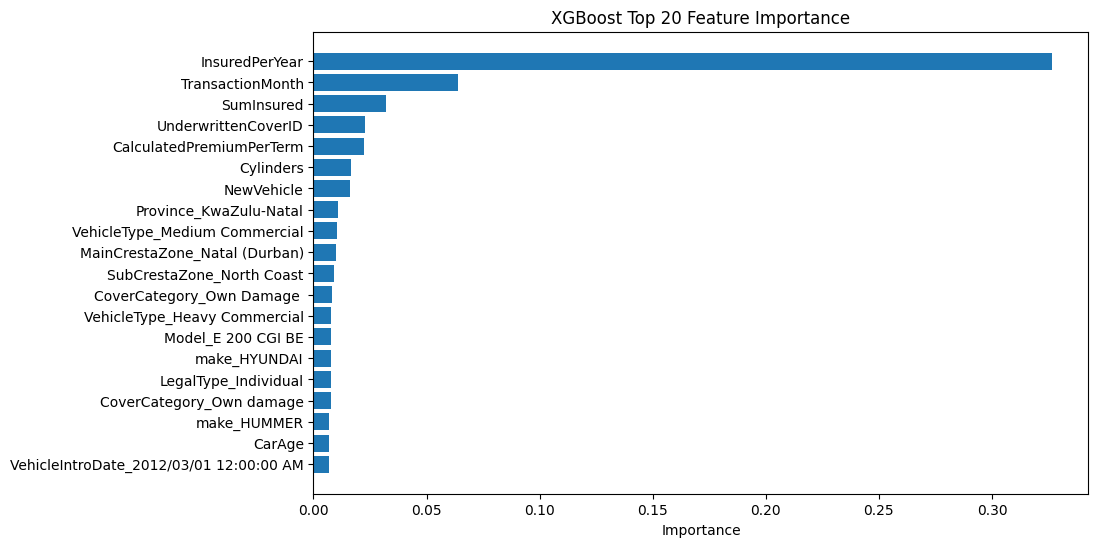

In [26]:
# XGBoost Feature Importance (assuming you have xgb_model trained)
xgb_importances = xgb_reg.feature_importances_
xgb_indices = np.argsort(xgb_importances)[-20:]  # Get indices of top 20 important features

plt.figure(figsize=(10, 6))
plt.barh(range(len(xgb_indices)), xgb_importances[xgb_indices], align='center')
plt.yticks(range(len(xgb_indices)), [X_train.columns[i] for i in xgb_indices])
plt.xlabel('Importance')
plt.title('XGBoost Top 20 Feature Importance')
plt.show()